In [2]:
from pennystockpipeline.PennyStockData import PennyStockData
from pennystockpipeline.PennyStockModeler import PennyStockModeler
import numpy as np
import pandas as pd
from time import gmtime, strftime
from datetime import datetime, timedelta

## Testing
table_name = "all_historical_modified"
database_name_with_path = "mod_historicaldata.db"

#columns = ['ticker_id', 'p_date', 'close', 'volume_weighted_average']
columns = ['ticker_id', 'p_date', 'p_time', 'volume_weighted_average']
columns_to_normalize = ['volume_weighted_average']

sequence_length = 36
prediction_length = 36

#psd = PennyStockData(database_name_with_path, table_name, impute=True, verbose=2).get_columns(columns).normalize(['close', 'volume_weighted_average']).create_sequences(sequence_length, prediction_length)
psd = PennyStockData(database_name_with_path, table_name, impute=True, verbose=2).get_columns(columns).normalize(columns_to_normalize).create_sequences(sequence_length, prediction_length)


[INFO][PennyStockData]: mod_historicaldata.db exists
[INFO][PennyStockData]: SQlite connected with mod_historicaldata.db
[INFO][PennyStockData]: SQlite executed query SELECT ticker_id, ticker, p_date, p_time, volume_weighted_average, open, close, high, low, time/1000 as time, volume, number_of_trades FROM all_historical_modified WHERE ticker_id<>30 ORDER BY ticker_id, p_date, p_time
[DEBUG][PennyStockData]: headers: ['ticker_id', 'ticker', 'p_date', 'p_time', 'volume_weighted_average', 'open', 'close', 'high', 'low', 'time', 'volume', 'number_of_trades']
[DEBUG][PennyStockData]: len(data): 549499
[INFO][PennyStockData]: SQlite executed query SELECT id, ticker FROM tickers WHERE id<>30 ORDER BY id
[DEBUG][PennyStockData]: Imputed len(data): 965607
Normalizing...
[INFO][PennyStockData]: Performing ticker-wise normalization on ['volume_weighted_average']
[INFO][PennyStockData]: Performing global normalization on ['volume_weighted_average'] using MixMaxScaler


In [3]:
df = pd.DataFrame(psd.normalized_data, columns=psd.normalized_headers)
df.head()

,p_date,p_time,volume_weighted_average
0,2022-07-12,16:30,0.228840
1,2022-07-12,16:35,0.229733
2,2022-07-12,16:40,0.229766
3,2022-07-12,16:45,0.229636
4,2022-07-12,16:50,0.228499


In [4]:
import torch # Library for implementing Deep Neural Network 

# Prepare model parameters
input_size = len(columns_to_normalize)
num_layers = 2
hidden_size = 64
output_size = len(columns_to_normalize)

# Define the model, loss function, and optimizer
modeler = PennyStockModeler(input_size, hidden_size, num_layers, device='cuda')
modeler = modeler.to(modeler.device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(modeler.parameters(), lr=1e-3)
print(modeler)

batch_size = 16
train_test_split = 0.8
# Split data into train and test sets and create dataloaders
modeler = modeler.split_dataset(psd, split=train_test_split, to_torch=True).create_dataloaders(batch_size)


PennyStockModeler(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
x_train.shape: torch.Size([17384, 36, 1]), y_train.shape: torch.Size([17384, 36, 1])
x_test.shape: torch.Size([4346, 36, 1]), y_test.shape: torch.Size([4346, 36, 1])


Epoch [10/10] - Training Loss: 0.0008, Test Loss: 0.0008


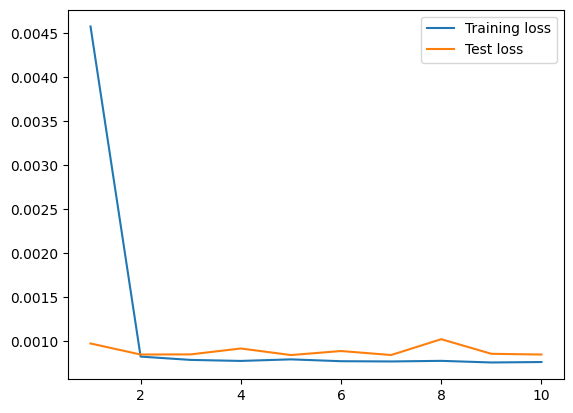

In [5]:
num_epochs = 10
# Train the model
modeler = modeler.train_model(loss_fn, optimizer, num_epochs = num_epochs).plot_training_test_loss()


In [6]:
type(modeler)

pennystockpipeline.PennyStockModeler.PennyStockModeler

In [7]:

def forecast(modeler, num_forecast_steps):
    psd_ds_dates = modeler.psd.ds_dates
    psd_ds_dates = [datetime.strptime(d, "%Y-%m-%d") for d in psd_ds_dates]
    last_date = max(psd_ds_dates)
    next_date = last_date + timedelta(days=1)

    #next_date = strftime("%Y-%m-%d", gmtime(next_date))
    print(type(psd_ds_dates))

    [psd_ds_dates.append(next_date) for steps in range(num_forecast_steps)]

    print(psd_ds_dates[0], psd_ds_dates[1], psd_ds_dates[-2], psd_ds_dates[-1])

    future_times = modeler.psd.ds_times[:num_forecast_steps]
    #modeler.psd.ds_times.append(future_times)
    
    
    # Generate the next 36 5-min intervals
    #future_dates = pd.date_range(start=pd.to_datetime(next_date, format='%Y-%m-%d'), end=pd.to_datetime(next_date, format='%Y-%m-%d'), periods=num_forecast_steps) # we would get 30 forecasted values in 5 mins interval
    #future_times = pd.interval_range(start=pd.to_datetime(start_time, format='%H:%M'), periods=num_forecast_steps, freq='5ME') # we would get 30 forecasted values in 5 mins interval

    #df_ds_dates = pd.DataFrame(modeler.psd.ds_dates, columns=['p_date'])
    #combined_dates_index = df_ds_dates.index.append(future_dates)
    
    #df_ds_times = pd.DataFrame(modeler.psd.ds_times, columns=['p_time'])
    #combined_times_index = df_ds_times.index.append(future_times)
    
    # Define the number of future time steps to forecast
    modeler.num_forecast_steps = num_forecast_steps
     
    # Convert to NumPy and remove singleton dimensions
    if modeler.device == 'cuda':
        sequence_to_plot = modeler.x_test.squeeze().cuda().numpy()
    else:
        sequence_to_plot = modeler.x_test.squeeze().cpu().numpy()
     
    # Use the last 36 data points as the starting point
    historical_data = sequence_to_plot[-1]
    print(historical_data.shape)
     
    # Initialize a list to store the forecasted values
    forecasted_values = []
     
    # Use the trained model to forecast future values
    with torch.no_grad():
        for _ in range(num_forecast_steps*2):
            # Prepare the historical_data tensor
            historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(modeler.device)
            # Use the model to predict the next value
            if modeler.device == 'cuda':
                predicted_value = modeler(historical_data_tensor).cuda().numpy()[0, 0]
            else:
                predicted_value = modeler(historical_data_tensor).cpu().numpy()[0, 0]
     
            # Append the predicted value to the forecasted_values list
            forecasted_values.append(predicted_value[0])
     
            # Update the historical_data sequence by removing the oldest value and adding the predicted value
            historical_data = np.roll(historical_data, shift=-1)
            historical_data[:-1] = predicted_value
    
    # Generate futute dates
    
    last_date = max(modeler.psd.ds_dates, key=lambda d: pd.to_datetime(d, format='%Y-%m-%d'))
    #last_date = datetime.strptime(last_date, '%Y-%m-%d')
    #print(last_date)
    #last_date = np.transpose().max()
    next_date = pd.to_datetime(last_date, format='%Y-%m-%d') + pd.DateOffset(1)

    start_time = "16:30"

    ft = pd.to_timedelta(np.arange(num_forecast_steps) * 5, unit='m')

    # Generate the next 36 5-min intervals
    future_dates = pd.date_range(start=pd.to_datetime(next_date, format='%Y-%m-%d'), end=pd.to_datetime(next_date, format='%Y-%m-%d'), periods=num_forecast_steps) # we would get 30 forecasted values in 5 mins interval
    future_times = pd.interval_range(start=pd.to_datetime(start_time, format='%H:%M'), periods=num_forecast_steps, freq='5ME') # we would get 30 forecasted values in 5 mins interval

    df_ds_dates = pd.DataFrame(modeler.psd.ds_dates, columns=['p_date'])
    combined_dates_index = df_ds_dates.index.append(future_dates)
    
    df_ds_times = pd.DataFrame(modeler.psd.ds_times, columns=['p_time'])
    combined_times_index = df_ds_times.index.append(future_times)
    
    # Concatenate the original index with the future dates
    modeler.forecasted_values = forecasted_values
    modeler.combined_dates_index = combined_dates_index
    modeler.combined_times_index = combined_times_index
    modeler.sequence_to_plot = sequence_to_plot

    print(len(forecasted_values))
    print(len(combined_dates_index))
    print(len(combined_times_index))
    #print(len(future_times))
    print(len(sequence_to_plot))
    
    return modeler





In [8]:
x = np.arange(36)
y = pd.to_timedelta(x, unit='min')

In [137]:
x = MinMaxScaler(feature_range=(0,1)) 
x.fit_transform(np.array([0.94, 0.97, 1, 0.84, 0.92, 1, 0.84]).reshape(-1, 1))

array([[0.625 ],
       [0.8125],
       [1.    ],
       [0.    ],
       [0.5   ],
       [1.    ],
       [0.    ]])

In [127]:
len(modeler.psd.ds_times)

965607

In [9]:
type(modeler)

pennystockpipeline.PennyStockModeler.PennyStockModeler

In [10]:
o_modeler = modeler
#modeler = modeler.forecast(num_forecast_steps = 30)
modeler = forecast(modeler, num_forecast_steps = 36)

<class 'list'>
2022-07-12 00:00:00 2022-07-12 00:00:00 2024-06-01 00:00:00 2024-06-01 00:00:00
(36,)
72
965643
965643
4346


In [11]:
type(modeler)

pennystockpipeline.PennyStockModeler.PennyStockModeler

In [121]:
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler

def plot_forecasting(modeler):
    df2 = pd.DataFrame(modeler.psd.normalized_data, columns=modeler.psd.normalized_headers)
    test_size = int(df2.shape[0] * (1-train_test_split))
    df2_test = df2[:test_size]
    #df2 = df2.drop(columns=['volume_weighted_average'])
    #df_normed = pd.DataFrame(modeler.psd.data, columns=modeler.psd.headers)
    #df2 = df2.join(df_normed, how="inner")
    # print(df2_test.shape[0])
    # print(df2_test.tail())
    # return
    
    forecasted_values = modeler.forecasted_values
    
    combined_dates_index = modeler.combined_dates_index
    combined_times_index = modeler.combined_times_index
    
    sequence_to_plot = modeler.sequence_to_plot
    
    #set the size of the plot 
    plt.rcParams['figure.figsize'] = [14, 4] 
    
    scaler = modeler.psd.scaler
    
    #Test data
    plt.plot(df2_test['p_time'][-72:-36], df2_test['volume_weighted_average'][-72:-36], label = "test_data", color = "b") 
    #reverse the scaling transformation
    original_cases = scaler[20].inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 
    
    #the historical data used as input for forecasting
    plt.plot(df2_test['p_time'][-36:], original_cases, label='actual values', color='green') 
    
    #Forecasted Values 
    #reverse the scaling transformation
    forecasted_cases = scaler[32].inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
    # plotting the forecasted values
    # print(df2_test['p_time'].index[-36:].shape, combined_times_index[-72:].shape, original_cases.shape, forecasted_cases.shape, "hotdog")
    # print(combined_dates_index)
    # print(forecasted_values)
    # print(original_cases)
    # print(original_cases, type(original_cases[0]))
    # print("---")
    # print(forecasted_cases, type(forecasted_cases[0]))
    # print("good")
    # print(df2_test['p_time'], type(df2_test['p_time'][0]))
    # print("---")
    # print(combined_times_index, type(combined_times_index[0]))
    # print("done")
    # print(df2)
    print("ALRIGHT\n\n")
    print(combined_times_index[-70:], len(combined_times_index))
    # start_times = combined_times_index.str.extract(r'\(([^,]+),')[0]
    # print(combined_times_index, type(combined_times_index))
    # print(start_times)

    # plt.plot(combined_times_index[-72:], forecasted_cases, label='forecasted values', color='red') 
    
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Time Series Forecasting')
    plt.grid(True)



ALRIGHT


Index([                                    965573,
                                           965574,
                                           965575,
                                           965576,
                                           965577,
                                           965578,
                                           965579,
                                           965580,
                                           965581,
                                           965582,
                                           965583,
                                           965584,
                                           965585,
                                           965586,
                                           965587,
                                           965588,
                                           965589,
                                           965590,
                                           965591,
                     

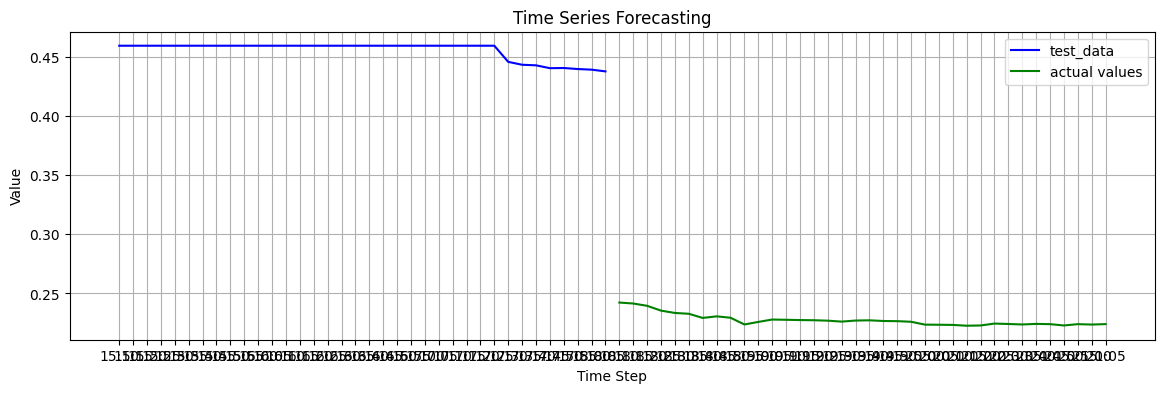

In [122]:
plot_forecasting(modeler)#, i_sequence_to_plot, i_forecasted_values, i_combined_index)

In [ ]:
print(modeler.psd.scaler.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33])
